<a href="https://colab.research.google.com/github/guanyuq03/ECON5200-Applied-Data-Analytics-in-Economics/blob/main/Assignment%203/Econ_5200_Assignment_3_Causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression

<h1>Phase 1: Bootstrapping Non-Parametric Uncertainty

<h2>Step 1.1: The Zero-Inflated Gig Economy Tip Distribution

In [2]:
# Data Generating Process
np.random.seed(42)
zeros = np.zeros(100)
tips = np.random.exponential(scale=5.0, size=150)
driver_tips = np.concatenate([zeros, tips])

<h2>Step 1.2: The Manual Bootstrap Engine

In [3]:
# Number of bootstrap resamples
n_boot = 10000

# Store bootstrap medians
boot_medians = np.zeros(n_boot)

# Get original sample size
sample_size = len(driver_tips)

# Resample with replacement n times
for i in range(n_boot):
  sample = np.random.choice(driver_tips, size=sample_size, replace=True)
  boot_medians[i] = np.median(sample)

# 95% confidence interval
ci = np.percentile(boot_medians, [2.5, 97.5])

print("Bootstrap median:", np.median(boot_medians))
print("95% Confidnece Interval:", ci)

Bootstrap median: 0.7553316913699188
95% Confidnece Interval: [0.26530184 1.36356392]


Discussion: The bootstrap confidence interval is asymmetric. The upper bound is farther from the median than the lower bound, because the distribution is heavily right-skewed. For instance, many drivers receive zero tips, which limits how small the median can be. Nevertheless, some bootstrap samples include fewer zeros and more large tips, which increases the median. A standard parametric confidence interval assumes symmetry, but this assumption does not hold in this zero-inflated distribution. In this case, the bootstrap method provides a more realistic measure of uncertainty.

<h1>Phase 2: Falsification in Logistics A/B Testing

<h2> Step 2.1: The Algorithmic Routing Crash

In [4]:
# Fix random seed
np.random.seed(42)

# Sample sizes
n_control = 500
n_treat = 500

# Control, Normal (mean=35, sd=5)
control = np.random.normal(loc=35, scale=5, size=n_control)

# Treatment, Log-normal (mean=3.4, sigma=0.4)
treatment = np.random.lognormal(mean=3.4, sigma=0.4, size=n_treat)

# Calculate the observed difference in means (control - treatment)
diff_means = control.mean() - treatment.mean()

print("Observed difference in means(Control - Treatment):", diff_means)

Observed difference in means(Control - Treatment): 2.2649821306257394


<h2> Step 2.2: The Exact Non-Parametric Permutation

In [5]:
# Combine all 1000 deliveries into one array
all_deliveries = np.concatenate([control, treatment])

# Number of random permutations
n = 5000
perm_diffs = np.zeros(n)

# Shuffle, split into two pseudo groups and calculate the mean difference
for i in range(n):
  shuffled = np.random.permutation(all_deliveries)
  pseudo_group1 = shuffled[:500]
  pseudo_group2 = shuffled[500:]
  perm_diffs[i] = pseudo_group1.mean() - pseudo_group2.mean()

# Empirical p-value
p_value = np.mean(np.abs(perm_diffs) >= np.abs(diff_means))
print("Empirical p-value:", p_value)

Empirical p-value: 0.0004


The p-value is 0.0004, meaning that out of the 5000 permutations, 0.04% produced differences in means at least as extreme as the observed difference.

<h1>Phase 3: Causal Control and the Mitigation of Selection Bias

<h2> Step 3.1: The Loyalty Program Paradox

In [6]:
# Load the dataset
df = pd.read_csv("swiftcart_loyalty.csv")
df.head()

,subscriber,pre_spend,account_age,support_tickets,post_spend
0,1,57.450712,37,2,85.169648
1,1,47.926035,41,0,72.802404
2,1,59.715328,41,0,79.858905
3,1,72.845448,34,0,80.335466
4,1,46.487699,34,2,67.956227


In [7]:
# Mean post-treatment spending for subscribers (D=1)
mean_sub = df[df["subscriber"] == 1]["post_spend"].mean()
# Mean post-treatment spending for non-subscribers (D=0)
mean_non = df[df["subscriber"] == 0]["post_spend"].mean()
# Calculate the naive simple difference in means SDO
sdo = mean_sub - mean_non
# Print results
print("Mean spending (subscribers):", mean_sub)
print("Mean spending (non-subscribers):", mean_non)
print("Naive Simple Difference in Means:", sdo)

Mean spending (subscribers): 74.04358604052543
Mean spending (non-subscribers): 56.47291665600164
Naive Simple Difference in Means: 17.57066938452379


<h2> Step 3.2: Propensity Score Matching (PSM) Architecture

In [8]:
# Pre-treatment covriates X and treatment indicator D
X = df[["pre_spend", "account_age", "support_tickets"]]
D = df["subscriber"]

# Estimate propensity score
logit = LogisticRegression()
logit.fit(X, D)

# Predicted probability of subscribing
df["propensity"] = logit.predict_proba(X)[:, 1]

# Split into treated and control groups
treated = df[df["subscriber"] == 1].copy()
control = df[df["subscriber"] == 0].copy()

# Match treated user to the closest control user
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[["propensity"]])
distances, indices = nn.kneighbors(treated[["propensity"]])

# Matched control observations
matched_control = control.iloc[indices.flatten()].copy()
# Align rows for doing subtraction
matched_control.index = treated.index

# Calculating the ATT
att = (treated["post_spend"] - matched_control["post_spend"]).mean()

# Calculate the deceptive naive SDO
naive_sdo = treated["post_spend"].mean() - control["post_spend"].mean()

print("Naive SDO:", naive_sdo)
print("ATT:", att)

Naive SDO: 17.57066938452379
ATT: 9.913855182824864


Comparison Analysis: Based on the output, the naive SDO is approximately 17.57. This suggests that subscribers spend much more than non-subscribers. However, after propensity score matching, the ATT decreases to approximately 9.91, which indicates that part of the naive difference was due to selection bias. For example, high-spending users are more likely to subscribe, so the naive estimate overstates the true causal effect of the SwiftPass program. So, the matched ATT is a more credible estimate of the program's impact.

<h1>Phase 4: AI Expansion (The Co-Pilot Era)

<h2>Task 4.1: The "Love Plot" Visualization Directive

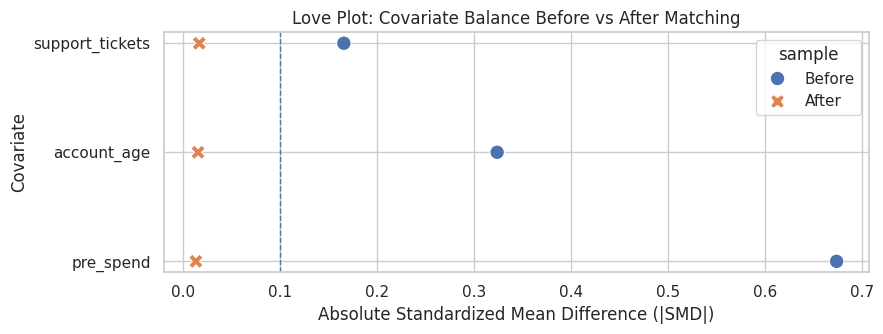

SMD Table (absolute values):
sample              After    Before
covariate                          
support_tickets  0.017112  0.166146
account_age      0.015871  0.324109
pre_spend        0.013664  0.673959


In [9]:
# -----------------------------------------
# Phase 4.1: Love Plot (SMD) for PSM Balance
# Uses: seaborn + matplotlib
# Assumes you already created: df, treated, matched_control
# -----------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# 1) Create the two dataframes required by the prompt
df_unmatched = df.copy()
df_matched = pd.concat([treated, matched_control], axis=0).reset_index(drop=True)

treat_col = "subscriber"

# 2) Choose covariates: all numeric pre-treatment features
# Exclude treatment, outcome, and propensity score
exclude_cols = {treat_col, "post_spend", "propensity"}

covariates = [
    c for c in df_unmatched.select_dtypes(include=[np.number]).columns
    if c not in exclude_cols
]

# 3) Function to compute SMD for one covariate
def smd(df_in, x_col, d_col):
    x_t = df_in[df_in[d_col] == 1][x_col].dropna()
    x_c = df_in[df_in[d_col] == 0][x_col].dropna()

    # pooled SD
    denom = np.sqrt((x_t.var(ddof=1) + x_c.var(ddof=1)) / 2)

    # avoid divide-by-zero
    if denom == 0 or np.isnan(denom):
        return np.nan

    return (x_t.mean() - x_c.mean()) / denom

# 4) Compute SMD before and after matching
rows = []
for c in covariates:
    rows.append({"covariate": c, "sample": "Before", "abs_smd": abs(smd(df_unmatched, c, treat_col))})
    rows.append({"covariate": c, "sample": "After",  "abs_smd": abs(smd(df_matched,   c, treat_col))})

plot_df = pd.DataFrame(rows).dropna()

# Order covariates by imbalance BEFORE matching (so the plot is easy to read)
order = (
    plot_df[plot_df["sample"] == "Before"]
    .sort_values("abs_smd", ascending=True)["covariate"]
    .tolist()
)
plot_df["covariate"] = pd.Categorical(plot_df["covariate"], categories=order, ordered=True)

# 5) Plot Love Plot
plt.figure(figsize=(9, max(3.5, 0.35 * len(order))))
sns.scatterplot(
    data=plot_df,
    x="abs_smd",
    y="covariate",
    hue="sample",
    style="sample",
    s=110
)

# Common balance threshold line
plt.axvline(0.1, linestyle="--", linewidth=1)

plt.title("Love Plot: Covariate Balance Before vs After Matching")
plt.xlabel("Absolute Standardized Mean Difference (|SMD|)")
plt.ylabel("Covariate")
plt.tight_layout()
plt.show()

# 6) Print SMD table (optional but helpful)
print("SMD Table (absolute values):")
print(plot_df.pivot(index="covariate", columns="sample", values="abs_smd"))